In [1]:
# 1. Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, Huber, CosineSimilarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [2]:
print(f"GPU:{tf.config.list_physical_devices('GPU')}, Platform:{platform.platform()}, Processor: {platform.machine()}")

GPU:[], Platform:macOS-13.5.2-arm64-arm-64bit, Processor: arm64


In [3]:
# 2. Utility Functions
def predict(model, data):
    predictions = model.predict(data)
    loss = np.mean(np.abs(data - predictions), axis=1)
    return predictions, loss

def plot_examples(model, data, ax, title):
    pred, loss = predict(model, data)
    ax.plot(data.flatten(), label="Actual")
    ax.plot(pred[0], label="Predicted")
    ax.fill_between(range(1, 189), data.flatten(), pred[0], alpha=0.3, color="r")
    ax.legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=7)
    ax.set_title(f"{title} (loss: {loss[0]:.3f})", fontsize=9.5)

def get_reconstruction_error(model, data):
    predictions = model.predict(data)
    return np.mean(np.abs(data - predictions), axis=1)

def classify_errors(errors, threshold):
    return np.array(errors > threshold, dtype=int)

In [4]:
# 3. Data Loading and Pre-processing
normal_df = pd.read_csv("data/ptbdb_normal.csv", sep=',').drop("target", axis=1, errors="ignore")
anomaly_df = pd.read_csv("data/ptbdb_abnormal.csv", sep=',').drop("target", axis=1, errors="ignore")

normal = normal_df.to_numpy()
anomaly = anomaly_df.to_numpy()
X_train, X_test = train_test_split(normal, test_size=0.15, random_state=45, shuffle=True)


In [5]:
# 4. Model Definition
class AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Reshape((input_dim, 1)),  # Reshape to 3D for Conv1D
            layers.Conv1D(64, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1D(64, 3, strides=1, activation='relu', padding="same"),
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(input_dim)
        ])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded


In [6]:
input_dim = X_train.shape[-1]
latent_dim = 32
epochs = 100
batch_size = 64
early_stopping = EarlyStopping(patience=10, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)
loss_functions = {'MAE': MeanAbsoluteError(), 'MSE': MeanSquaredError(), 'Huber': Huber(), 'CosineSimilarity': CosineSimilarity()}
best_loss = float('inf')
best_model = None
best_loss_function = None


In [7]:
# Ground truth for validation
y_true_normal = np.zeros(len(X_test))
y_true_anomaly = np.ones(len(anomaly))
y_test = np.concatenate([y_true_normal, y_true_anomaly])
X_combined_test = np.concatenate([X_test, anomaly])


Using legacy optimizer for M1/M2 Mac.


2023-10-23 02:06:19.877736: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


348/348 [==============================] - 2s 4ms/step
Validation Accuracy using MAE: 99.66%
Validation Reconstruction Error using MAE: 0.05682646798069612
1/1 [==============================] - 0s 9ms/step


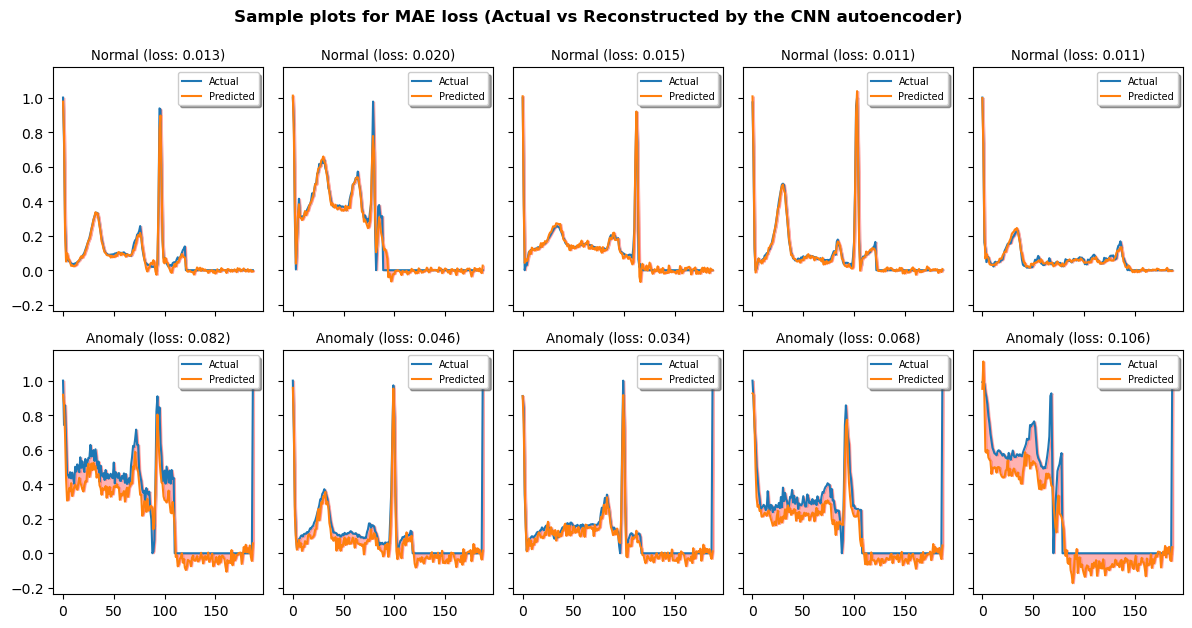

Using legacy optimizer for M1/M2 Mac.
348/348 [==============================] - 1s 4ms/step
Validation Accuracy using MSE: 11.74%
Validation Reconstruction Error using MSE: 0.7075693809550808
1/1 [==============================] - 0s 9ms/step


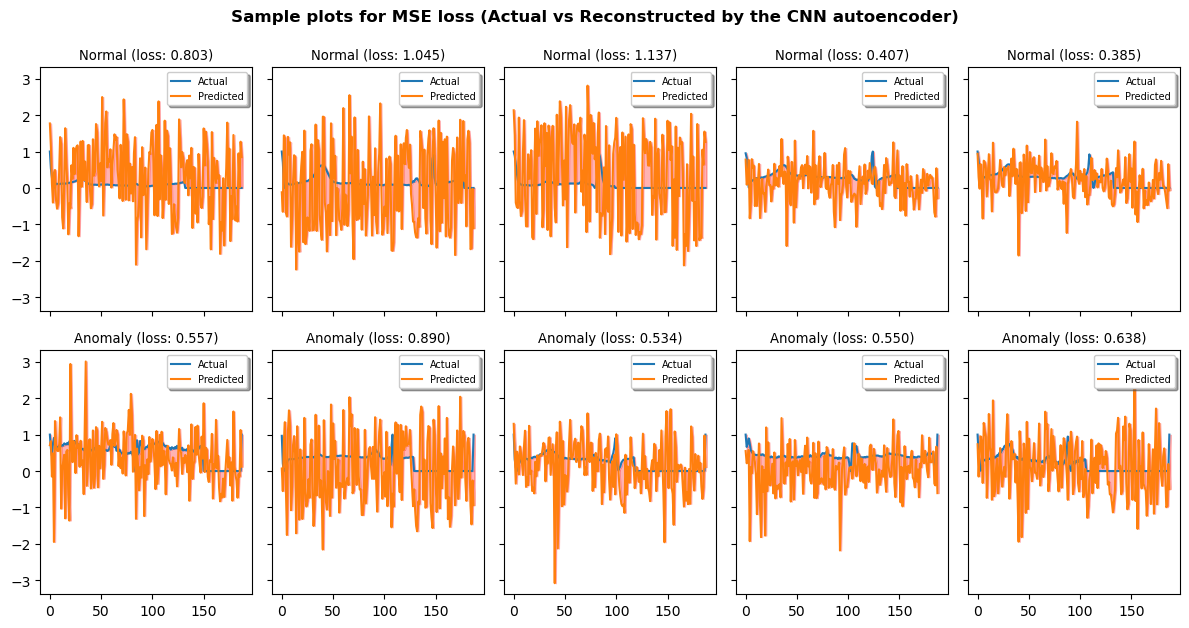

Using legacy optimizer for M1/M2 Mac.
348/348 [==============================] - 1s 4ms/step
Validation Accuracy using Huber: 99.77%
Validation Reconstruction Error using Huber: 0.6126648600475101
1/1 [==============================] - 0s 10ms/step


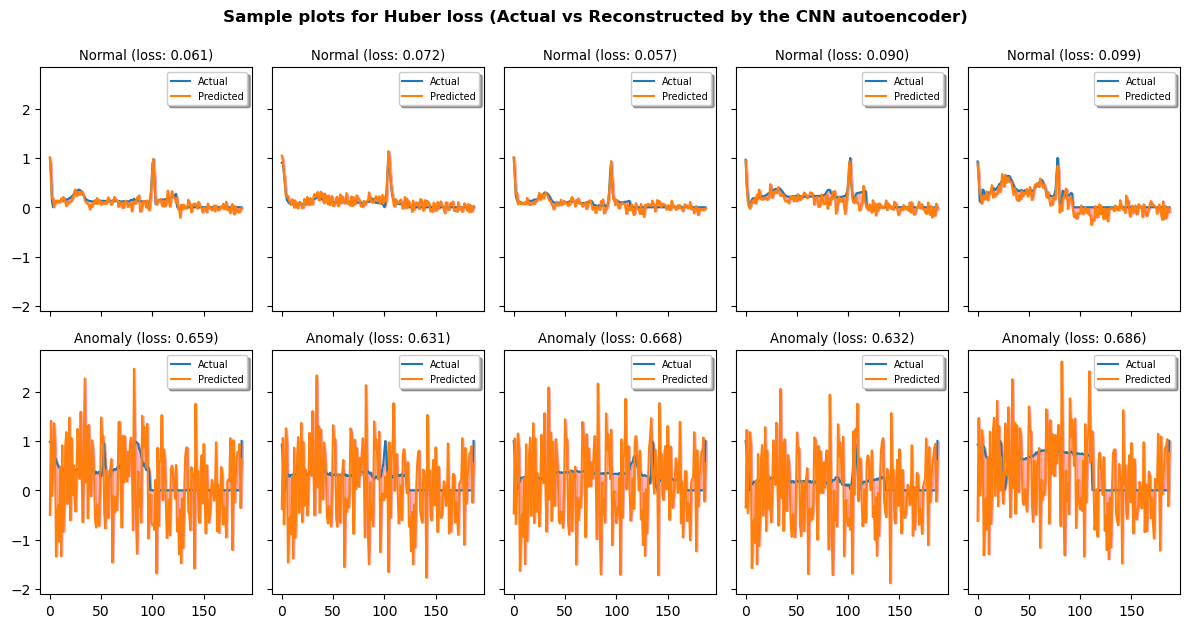

Using legacy optimizer for M1/M2 Mac.
348/348 [==============================] - 2s 5ms/step
Validation Accuracy using CosineSimilarity: 11.09%
Validation Reconstruction Error using CosineSimilarity: 43.92704578555664
1/1 [==============================] - 0s 11ms/step


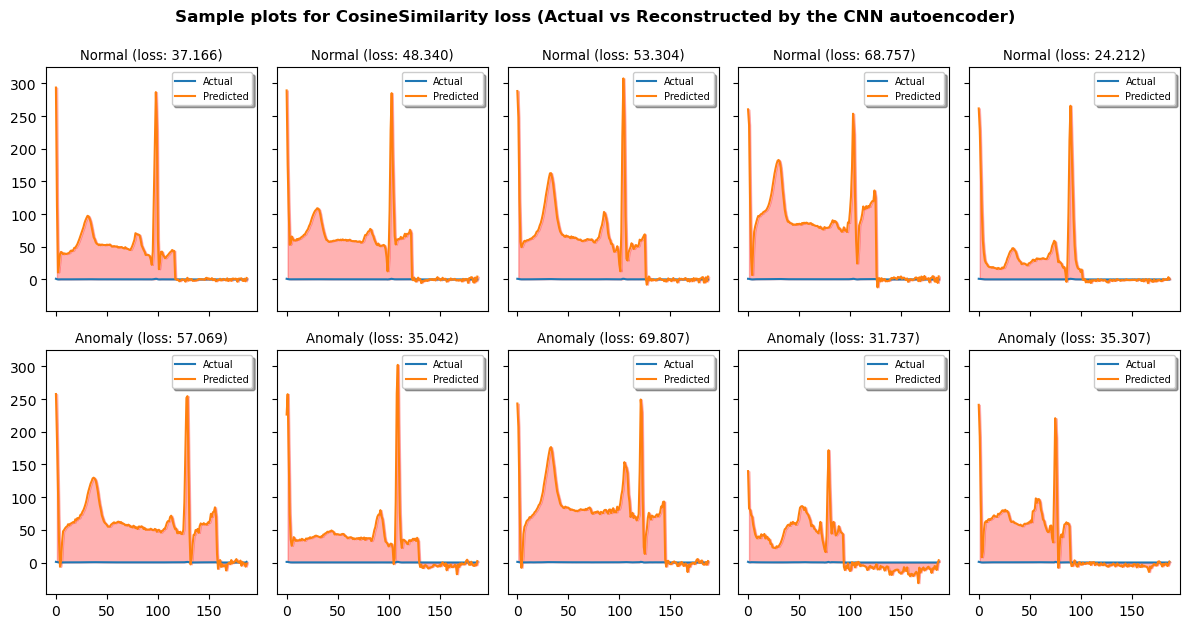

Best Model uses MAE with average validation error: 0.05682646798069612


In [8]:
# Train and evaluate models for each loss function
for name, loss_function in loss_functions.items():
    # Define and compile the model
    model = AutoEncoder(input_dim, latent_dim)
    model.build((None, input_dim))
    # Check if the machine is using an M1/M2 processor
    if "macOS-13.5.2-arm64-arm-64bit" in platform.platform() and "arm64" in platform.machine():
        model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01), loss=loss_function)
        print("Using legacy optimizer for M1/M2 Mac.")
    elif tf.config.list_physical_devices('GPU'):  # Check if there are any GPUs available
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=loss_function)
        print("Using standard optimizer for GPU.")
    else:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=loss_function)
        print("Using standard optimizer for conventional CPU.")


    # Train the model
    model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
              validation_split=0.1, callbacks=[early_stopping], verbose=0)

    # Calculate the threshold based on the training data
    train_errors = get_reconstruction_error(model, X_train)
    threshold = np.percentile(train_errors, 95)  # 95th percentile as threshold

    # Evaluate the model on combined validation data (normal + anomaly) using the calculated threshold
    val_errors = get_reconstruction_error(model, X_combined_test)
    y_pred_val = np.array(val_errors > threshold, dtype=int)

    accuracy = accuracy_score(y_test, y_pred_val)

    print(f"Validation Accuracy using {name}: {accuracy:.2%}")
    print(f"Validation Reconstruction Error using {name}: {np.mean(val_errors)}")

    # After training, visualize the reconstructions for this specific model
    fig, axes = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(12, 6))
    random_indexes = np.random.randint(0, len(X_train), size=5)
    for i, idx in enumerate(random_indexes):
        data = X_train[[idx]]
        plot_examples(model, data, ax=axes[0, i], title="Normal")
    for i, idx in enumerate(random_indexes):
        data = anomaly[[idx]]
        plot_examples(model, data, ax=axes[1, i], title="Anomaly")
    plt.tight_layout()
    fig.suptitle(f"Sample plots for {name} loss (Actual vs Reconstructed by the CNN autoencoder)", y=1.04, weight="bold")
    plt.show()

    # Check if current model is the best
    if np.mean(val_errors) < best_loss:
        best_loss = np.mean(val_errors)
        best_model = model
        best_loss_function = name

print(f"Best Model uses {best_loss_function} with average validation error: {best_loss}")

In [9]:
# 6. Evaluation
threshold = np.percentile(get_reconstruction_error(best_model, X_train), 95)
normal_errors = get_reconstruction_error(best_model, X_test)
anomaly_errors = get_reconstruction_error(best_model, anomaly)
y_pred_normal = classify_errors(normal_errors, threshold)
y_pred_anomaly = classify_errors(anomaly_errors, threshold)
y_true_normal = np.zeros_like(y_pred_normal)
y_true_anomaly = np.ones_like(y_pred_anomaly)
y_pred = np.concatenate([y_pred_normal, y_pred_anomaly])
y_true = np.concatenate([y_true_normal, y_true_anomaly])
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

329/329 [==============================] - 2s 6ms/step
Accuracy: 99.66%
Precision: 99.64%
Recall: 100.00%
F1 Score: 99.82%


Text(0.5, 36.72222222222221, 'Predicted Class')

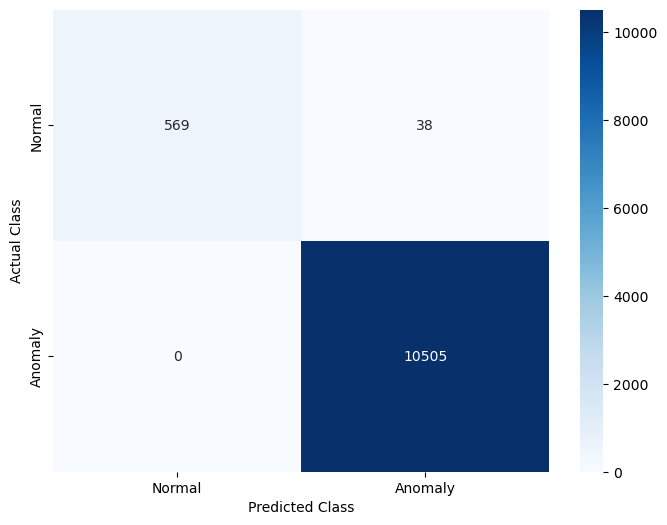

In [10]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')